In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd "/content/drive/MyDrive/NYU/DL Systems/004-HW2"
!ls -l

/content/drive/MyDrive/NYU/DL Systems/004-HW2
total 739
-rw------- 1 root root 157059 Feb 25 20:03 'CSCI_GA_3033_091_Homework_2__Spring_2022 (1).pdf'
drwx------ 2 root root   4096 Oct 12  2020  cyclical_finder
-rw------- 1 root root 304776 Mar  4 00:09  HW2.ipynb
drwx------ 2 root root   4096 Mar  1 17:44  MNIST
-rw------- 1 root root  92952 Mar  2 05:40  part2_weight_initializers.h5
-rw------- 1 root root 192784 Mar  2 05:40  sigmoid_stdev_0.01_init_model.h5


# Problem 1 - *Perceptron*


## 1.1

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
import random
from tqdm.notebook import tqdm

In [105]:
# Let's make the dataset
np.random.seed(10)
train_size=10
test_size=5000

def make_instances(n):
    xs = [np.random.uniform(0, 1, size=2) for _ in range(n)]
    ys = [1 if x[0] > x[1] else -1 for x in xs]
    return np.array(xs), np.array(ys)

train_x, train_y = make_instances(train_size)
test_x, test_y = make_instances(test_size)

In [106]:
# Implement the perceptron
class Perceptron:
    def __init__(self, input_size, loss_fn):
        self.weights = np.zeros(input_size)
        self.loss_fn = loss_fn
        
    def predict(self, x):
        res = np.dot(self.weights, x)
        return self.sign(res)
    
    def sign(self, x):
        return 1 if x > 0 else -1
    
    def get_error(self, x, y):
        a = 0 if self.loss_fn == "perceptron" else 1
        return a - (y * (x @ self.weights))
    
    def keep_training(self, preds, ys):
        if self.loss_fn == "perceptron":
            return self.count_mispredictions(preds, ys) > 0
        else:
            return True
        
    def count_mispredictions(self, preds, ys):
        return len(np.where(preds != ys)[0]) 
    
    def train(self, xs, ys, lr):
        preds = np.zeros(len(ys))
        max_iter = 1000
        i = 0
        while self.keep_training(preds, ys):
        # for i in range(n_epoch):
            total_loss = 0
            total_incorrect = 0
            for idx, (x, y) in enumerate(zip(xs, ys)):
                preds[idx] = self.predict(x)
                # Get prediction error
                error = self.get_error(x, y)
                # If prediction error > threshold
                if error >= 0:
                    # Update the model weights
                    self.weights += lr * x * y
                    
            i += 1
            if i > max_iter:
                break

In [107]:
perceptron = Perceptron(2, "perceptron")
perceptron.train(train_x, train_y, 0.1)

preds = [perceptron.predict(x) for x in test_x]
print(f"Perceptron Criterion accuracy: {accuracy_score(test_y, preds)}")

Perceptron Criterion accuracy: 0.901


In [108]:
perceptron = Perceptron(2, "hinge")
perceptron.train(train_x, train_y, 0.1)

preds = [perceptron.predict(x) for x in test_x]
print(f"Hinge loss accuracy: {accuracy_score(test_y, preds)}")

Hinge loss accuracy: 0.9844


## 1.3

We obtain better test accuracy using **hinge loss**. This is because the hinge loss enforces a wider margin for the separating hyperplane, while the perceptron criterion allows any seperating hyperplane (even if not optimally separating the training data).

## 1.4

The classification of these 5000 test instances is less likely to change significantly with a different training set if we use **hinge loss**. Given we have a very small, sparse dataset (only 10 points), a new set is likely to be quite different. This means that our model trained with the perceptron criterion (which learns any seperating hyperplane) will change significantly with a new training set, while the margin enforced by hinge loss will push the classifier closer to the true separating hyperplane ($x_1 - x_2$).

# Problem 2 - *Weight Initialization, Dead Neurons, Leaky ReLU*

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.initializers import normal, glorot_normal, he_normal

from deepreplay.callbacks import ReplayData
from deepreplay.replay import Replay
from deepreplay.plot import compose_plots

from matplotlib import pyplot as plt

## 2.1

In [4]:
def build_model(n_layers, input_dim, units, activation, initializer):
    if isinstance(units, list):
        assert len(units) == n_layers
    else:
        units = [units] * n_layers
        
    model = Sequential()
    # Adds first hidden layer with input_dim parameter
    model.add(Dense(units=units[0], 
                    input_dim=input_dim, 
                    activation=activation,
                    kernel_initializer=initializer, 
                    name='h1'))
    
    # Adds remaining hidden layers
    for i in range(2, n_layers + 1):
        model.add(Dense(units=units[i-1], 
                        activation=activation, 
                        kernel_initializer=initializer, 
                        name='h{}'.format(i)))
    
    # Adds output layer
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer=initializer, name='o'))
    # Compiles the model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])
    return model

In [5]:
from deepreplay.datasets.ball import load_data

X, y = load_data(n_dims=10)

In [8]:
def plot_config(filename, group_name, init, actv):
    # Builds BLOCK model
    model = build_model(n_layers=5, input_dim=10, units=100, 
                    activation=actv, initializer=init)
    
    # Since we only need initial weights, we don't even need to train the model! 
    # We still use the ReplayData callback, but we can pass the model as argument instead
    replaydata = ReplayData(X, y, filename=filename, group_name=group_name, model=model)
    
    # Now we feed the data to the actual Replay object
    # so we can build the visualizations
    replay = Replay(replay_filename=filename, group_name=group_name)
       
    # Using subplot2grid to assemble a complex figure...
    fig = plt.figure(figsize=(12, 6))
    ax_zvalues = plt.subplot2grid((2, 2), (0, 0))
    ax_weights = plt.subplot2grid((2, 2), (0, 1))
    ax_activations = plt.subplot2grid((2, 2), (1, 0))
    ax_gradients = plt.subplot2grid((2, 2), (1, 1))

    wv = replay.build_weights(ax_weights)
    gv = replay.build_gradients(ax_gradients)
    # Z-values
    zv = replay.build_outputs(ax_zvalues, before_activation=True, 
                              exclude_outputs=True, include_inputs=False)
    # Activations
    av = replay.build_outputs(ax_activations, exclude_outputs=True, include_inputs=False)

    # Finally, we use compose_plots to update all
    # visualizations at once
    fig = compose_plots([zv, wv, av, gv], 
                            epoch=0, 
                            title=f'Activation: {act} - Initializer: Normal $\sigma = {std}$')



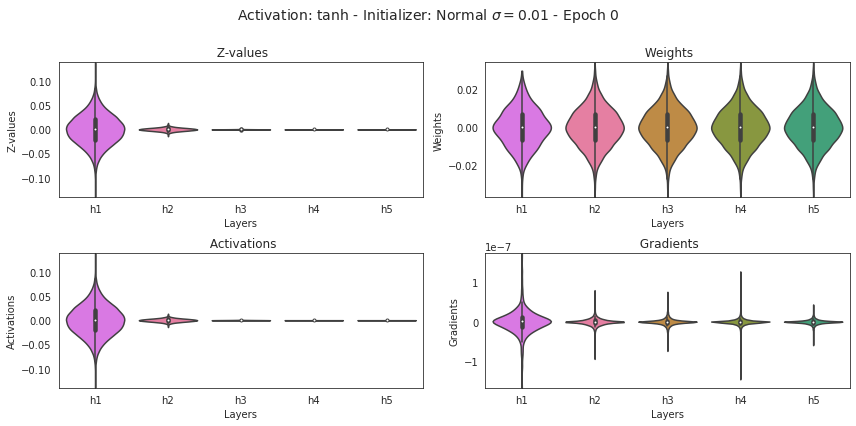

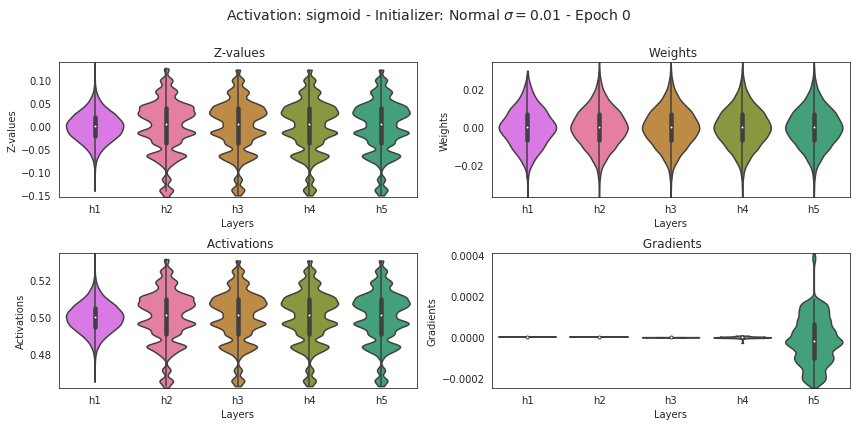

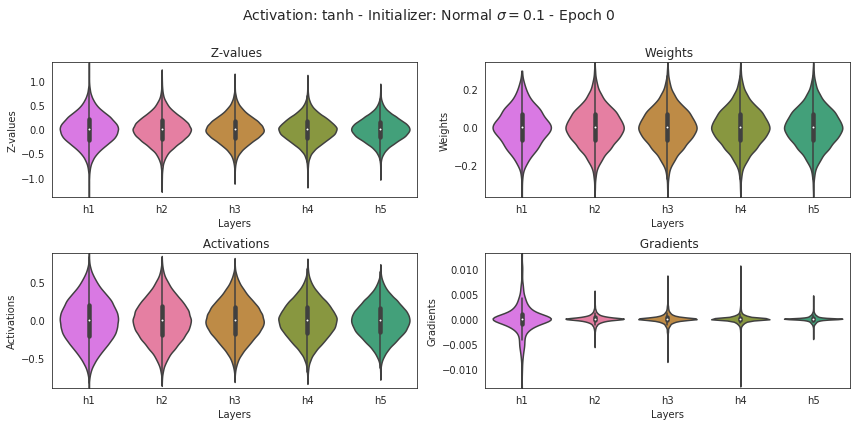

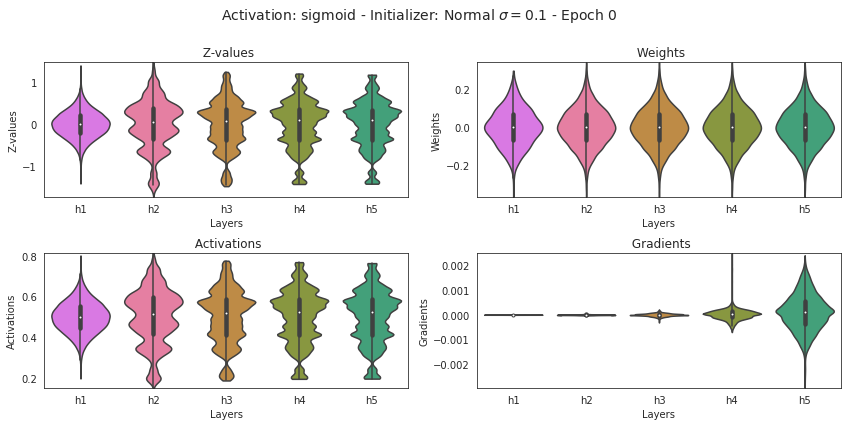

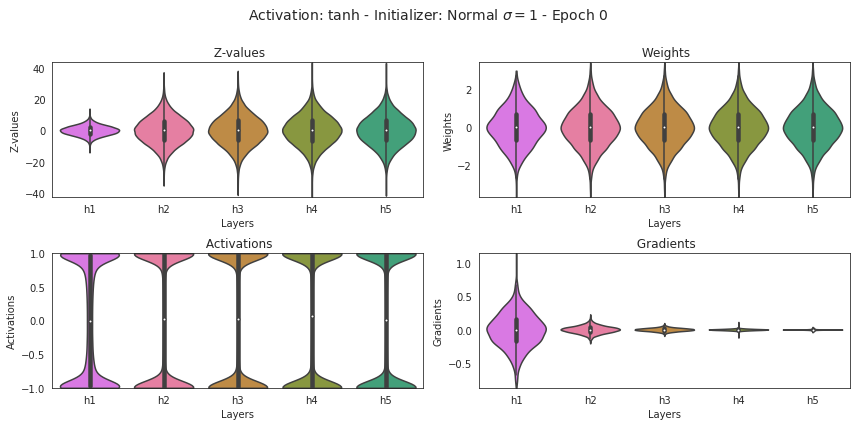

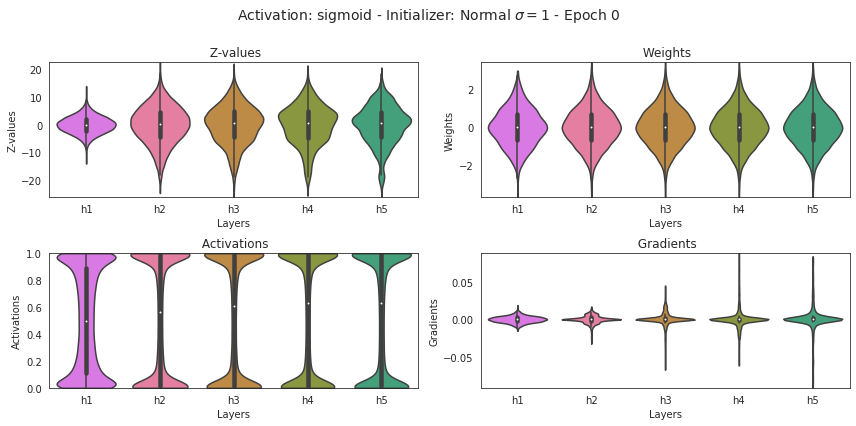

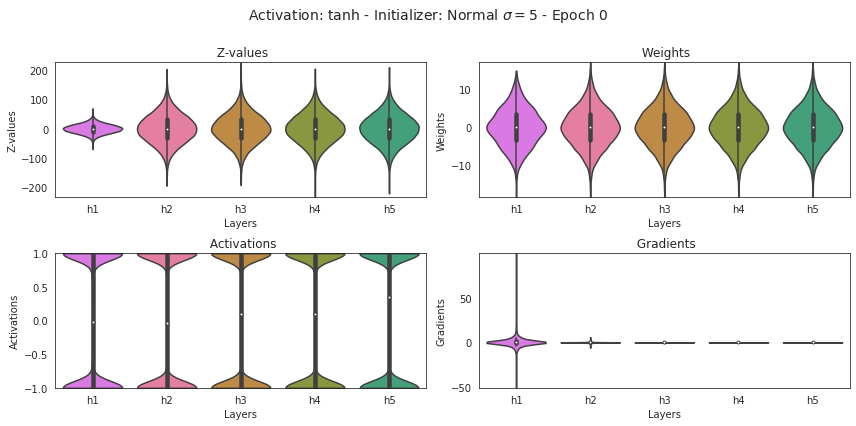

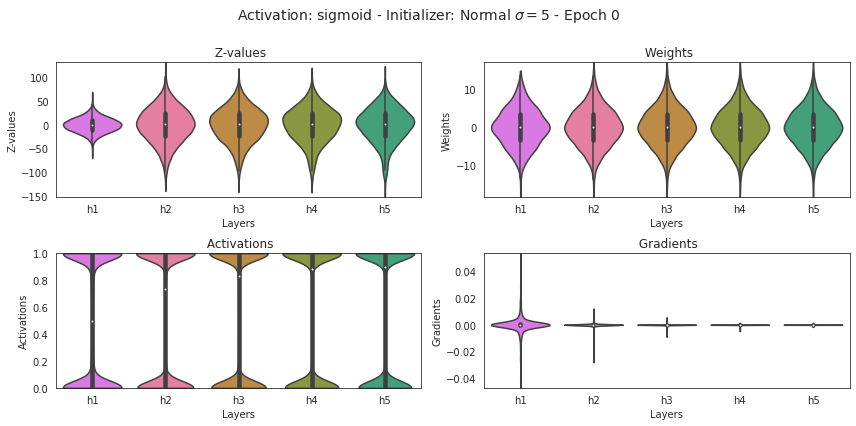

In [11]:
stds = [0.01, 0.1, 1, 5]
activations = ['tanh', 'sigmoid']

for std in stds:
    for act in activations:
        filename = f'normal_init_{act}_{std}'
        group_name = f'normal_{act}_{std}'
        
        init = normal(mean=0, stddev=std, seed=13)
        
        plot_config(filename, group_name, init, act)

Now we'll initialize using glorot normal (ignore $\sigma$ in title, this variable is not used)

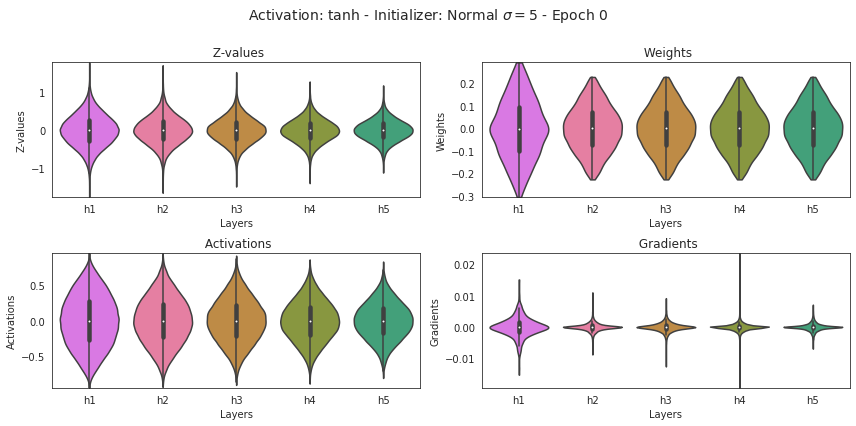

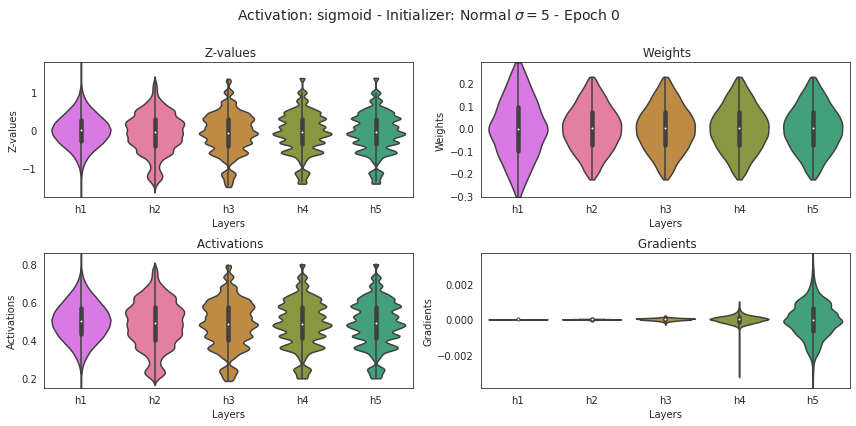

In [15]:
for act in activations:
    filename = f'glorot_init_{act}_{std}'
    group_name = f'glorot_{act}_{std}'

    init = glorot_normal(seed=13)

    plot_config(filename, group_name, init, act)

Now intead of sigmoid/tanh, we'll use ReLU as the activation function (still with Glorot)

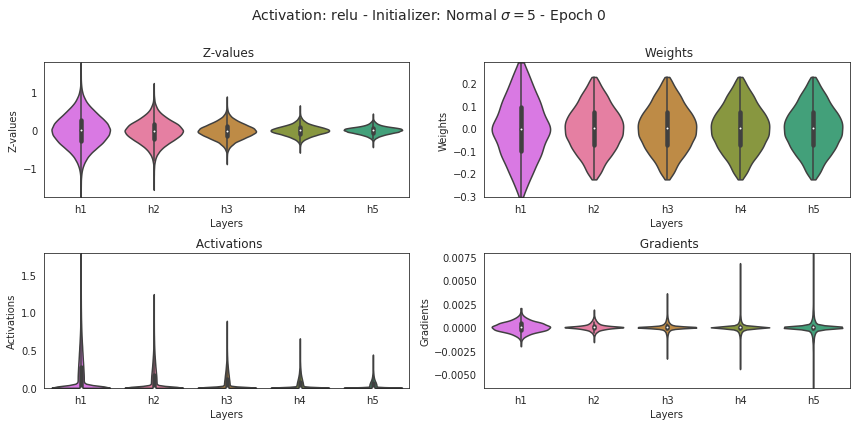

In [16]:
act = "relu"

filename = f'relu_init_{act}'
group_name = f'relu_{act}'

init = glorot_normal(seed=13)

plot_config(filename, group_name, init, act)

And finally show ReLU activation with He Initialization

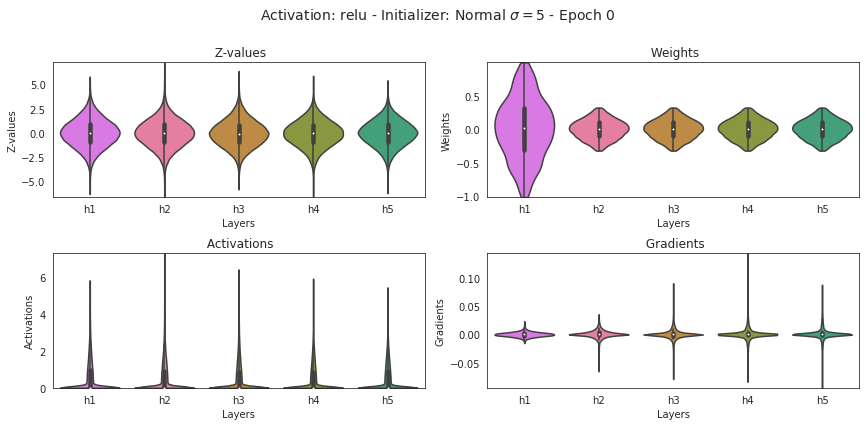

In [20]:
act = "relu"

filename = f'he_init_{act}'
group_name = f'he_{act}'

init = he_normal(seed=15)

plot_config(filename, group_name, init, act)

## 2.2

In [23]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cpu


In [80]:
import numpy as np
np.random.seed(0)
from torch.utils.data import Dataset
from torch import nn
import torch
from tqdm import tqdm

num_instances = 3000
num_simulations = 1000
num_epochs = 2

X = np.random.uniform(-np.sqrt(7), np.sqrt(7), (num_simulations, num_instances))
Y = np.abs(X)

class BasicDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [81]:
class ReluNet(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )
        
    def forward(self, x):
        return self.model(x)
            

In [82]:
num_collapse = 0

for i in tqdm(range(num_simulations)):
    model = ReluNet(num_hidden=2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    
    train_x = X[i]
    train_y = Y[i]
    
    ds = BasicDataset(train_x, train_y)
    dataloader = torch.utils.data.DataLoader(ds, batch_size=32)
    
    for epoch_i in range(num_epochs):
        
        for i, (x_batch, y_batch) in enumerate(dataloader):
            x_batch = x_batch.unsqueeze(1).float()
            y_batch = y_batch.float()
            
            preds = model(x_batch)
            # print(preds.size(), train_y
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    if len(preds.unique()) == 1:
        num_collapse += 1

100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]


In [83]:
print(f"{num_collapse}/{num_simulations} collapsed: ({(num_collapse / num_simulations) * 100})")

926/1000 collapsed: (92.60000000000001)


92% of the networks collapsed, which backs up Lu et al.

## 2.3

In [84]:
class LeakyReluNet(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, num_hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(num_hidden, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [85]:
num_collapse = 0

for i in tqdm(range(num_simulations)):
    model = LeakyReluNet(num_hidden=2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    
    train_x = X[i]
    train_y = Y[i]
    
    ds = BasicDataset(train_x, train_y)
    dataloader = torch.utils.data.DataLoader(ds, batch_size=32)
    
    for epoch_i in range(num_epochs):
        
        for i, (x_batch, y_batch) in enumerate(dataloader):
            x_batch = x_batch.unsqueeze(1).float()
            y_batch = y_batch.float()
            
            preds = model(x_batch)
            # print(preds.size(), train_y
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    if len(preds.unique()) == 1:
        num_collapse += 1

100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


In [86]:
print(f"{num_collapse}/{num_simulations} collapsed: ({(num_collapse / num_simulations) * 100})")

771/1000 collapsed: (77.10000000000001)


Fewer of the networks collapsed, so LeakyReLU does in fact help in preventing dying neurons

# Problem 3 - *Batch Normalization, Dropout, MNIST*

## 3.1

**Co-adaptation** is a phenomenon where through training, neurons become highly dependent on other neurons, learning similar/the same features. This is a common cause for overfitting, and can usually be effectively mitigated through the use of dropout

**Covariance Shift** is a phenomenon when the distribution of the covariates (i.e., the input features) shifts between training and testing/deployment (even if the target remains stable). A key assumption of machine learning is the covariate distribution is fixed, which is what allows the model's learned features to be effective in production; if the covariates shift in a live environment (e.g., due to data collection, environmental factors, time, etc.), the model's performance can degrade significantly.

In the context of batch normalization, **covariance shift** refers to the updated weights causing different data to be processed through the network, i.e., the inputs to each neuron is slightly different every iteration. Batch normalization fixes this by ensuring the outputs of each layer maintain a stable distribution.

## 3.2

In [87]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [88]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

### Helper Functions

In [89]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return float(correct_pred.float() / n)

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    train_accs = []
    val_accs = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            train_accs.append(train_acc)
            val_accs.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
    
    return model, optimizer, (train_losses, valid_losses), (train_accs, val_accs)

### Data

In [90]:
def get_mean_std(dataset):
    loader = DataLoader(dataset=dataset, batch_size=len(dataset), num_workers=1)
    data = next(iter(loader))
    return data[0].mean(), data[0].std()

# transforms.ToTensor() automatically scales the images to [0,1] range
pre_tfs = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
pre_train_dataset = datasets.MNIST(root='./', 
                               train=True, 
                               transform=pre_tfs,
                               download=True)

# Calculate the training mean/std
# TODO do over train/val or just train
mean, std = get_mean_std(pre_train_dataset)

print(f"Mean: {mean}, std: {std}")

# Now reload MNIST using the mean and std to normalize
tfs = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),
                                  transforms.Normalize(mean, std)])

train_dataset = datasets.MNIST(root='./', 
                               train=True, 
                               transform=tfs,
                               download=True)

val_dataset = datasets.MNIST(root='./', 
                               train=False,
                               transform=tfs,
                                download=True)

# Build the normalized dataloader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Mean: 0.13090024888515472, std: 0.2892882525920868


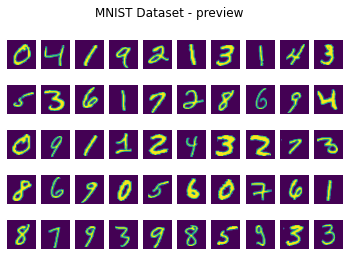

In [91]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

### Model

In [92]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, input_tf, model_tf):
        super(LeNet5, self).__init__()

        self.tf_layers = []

        # Set input layer transforms
        if input_tf == "norm":
            # Data should be normalised before input to the model
            self.tf_layers.append(nn.Identity())
            self.tf_layers.append(nn.Identity())
        elif input_tf == "bn":
            self.tf_layers.append(nn.BatchNorm2d(num_features=1))
            self.tf_layers.append(nn.Identity())
        elif input_tf == "dropout":
            self.tf_layers.append(nn.Dropout(p=0.2))
            self.tf_layers.append(nn.Identity())
        elif input_tf == "bn_dropout":
            self.tf_layers.append(nn.BatchNorm2d(num_features=1))
            self.tf_layers.append(nn.Dropout(p=0.2))
        else:
            raise Exception("Invalid input transform arg")

        # Set hidden layer transforms
        bn_features = [6, 16, 120, 84]
        for num in bn_features:
            if model_tf == "bn":
                bn_layer = nn.BatchNorm1d(num_features=num) if num == bn_features[-1] else nn.BatchNorm2d(num_features=num)
                self.tf_layers.append(bn_layer)
                self.tf_layers.append(nn.Identity())
            elif model_tf == "dropout":
                self.tf_layers.append(nn.Dropout(p=0.5))
                self.tf_layers.append(nn.Identity())
            elif model_tf == "bn_dropout":
                bn_layer = nn.BatchNorm1d(num_features=num) if num == bn_features[-1] else nn.BatchNorm2d(num_features=num)
                self.tf_layers.append(bn_layer)
                self.tf_layers.append(nn.Dropout(p=0.5))
            else:
                raise Exception("Invalid model transform arg")

        # Actually construct our model
        self.feature_extractor = nn.Sequential(      
            self.tf_layers[0],
            self.tf_layers[1],
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            self.tf_layers[2],
            self.tf_layers[3],
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            self.tf_layers[4],
            self.tf_layers[5],
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            self.tf_layers[6],
            self.tf_layers[7],
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            self.tf_layers[8],
            self.tf_layers[9],
            nn.Linear(in_features=84, out_features=n_classes),
        )

        print(f"Finished construction model with input_tf: {input_tf} and model_tf: {model_tf}")
        print("TF layers: ", self.tf_layers)
        print(self)


    def get_bn_params(self, to_float):
        bn_layers = [layer for layer in self.tf_layers if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d)]
        bn_params = []
        for layer in bn_layers:
            params = list(layer.parameters())
            if to_float:
                bn_params.append(([float(p) for p in params[0]], 
                       [float(p) for p in params[1]]))
            else:
                bn_params.append((params[0], params[1]))
            
        return bn_params

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [93]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(N_CLASSES, input_tf="norm", model_tf="bn").to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Finished construction model with input_tf: norm and model_tf: bn
TF layers:  [Identity(), Identity(), BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity(), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity(), BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity(), BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity()]
LeNet5(
  (feature_extractor): Sequential(
    (0): Identity()
    (1): Identity()
    (2): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (3): Tanh()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Identity()
    (7): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_

In [94]:
norm_model, norm_optimizer, norm_losses, norm_accs = training_loop(model, criterion, optimizer, train_loader, val_loader, N_EPOCHS, DEVICE)

15:23:46 --- Epoch: 0	Train loss: 0.1405	Valid loss: 0.0551	Train accuracy: 98.44	Valid accuracy: 98.35
15:24:18 --- Epoch: 1	Train loss: 0.0654	Valid loss: 0.0444	Train accuracy: 98.86	Valid accuracy: 98.60
15:24:50 --- Epoch: 2	Train loss: 0.0497	Valid loss: 0.0463	Train accuracy: 98.98	Valid accuracy: 98.68
15:25:23 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0365	Train accuracy: 99.24	Valid accuracy: 98.77
15:25:55 --- Epoch: 4	Train loss: 0.0361	Valid loss: 0.0376	Train accuracy: 99.20	Valid accuracy: 98.91
15:26:27 --- Epoch: 5	Train loss: 0.0336	Valid loss: 0.0361	Train accuracy: 99.32	Valid accuracy: 98.91
15:26:59 --- Epoch: 6	Train loss: 0.0296	Valid loss: 0.0316	Train accuracy: 99.54	Valid accuracy: 98.98
15:27:31 --- Epoch: 7	Train loss: 0.0269	Valid loss: 0.0413	Train accuracy: 99.40	Valid accuracy: 98.75
15:28:03 --- Epoch: 8	Train loss: 0.0260	Valid loss: 0.0359	Train accuracy: 99.58	Valid accuracy: 99.03
15:28:35 --- Epoch: 9	Train loss: 0.0232	Valid loss: 0.0425	Trai

In [95]:
# Print the learned parameters for each batch norm layer
print("Learned batch norm parameters are:")
for params in norm_model.get_bn_params(to_float=False):
    print(params)
    print()

Learned batch norm parameters are:
(Parameter containing:
tensor([0.9379, 1.0277, 0.9004, 0.9363, 0.9538, 1.3554], requires_grad=True), Parameter containing:
tensor([ 0.3574,  0.3814,  0.0530,  0.4017, -0.1596, -0.0717],
       requires_grad=True))

(Parameter containing:
tensor([0.8210, 0.8920, 1.3418, 0.8048, 0.3829, 0.4547, 0.8970, 0.7969, 0.7055,
        0.7415, 0.7402, 0.7735, 0.8380, 1.0593, 0.7831, 0.7889],
       requires_grad=True), Parameter containing:
tensor([-0.1176,  0.0196, -0.1482,  0.1542,  0.0198,  0.0271, -0.1758, -0.0381,
        -0.0139, -0.0752, -0.0992,  0.0696,  0.1014, -0.0892, -0.0916,  0.0637],
       requires_grad=True))

(Parameter containing:
tensor([1.0367, 1.0172, 1.0512, 1.0530, 0.7392, 0.9374, 1.0626, 1.0513, 1.0907,
        0.9215, 0.9901, 1.1656, 0.9749, 0.9199, 1.1200, 0.9507, 0.8275, 1.0073,
        0.9258, 1.0199, 1.0151, 0.9219, 0.7832, 1.1195, 1.2316, 1.0027, 1.0557,
        0.9101, 0.6782, 1.2299, 0.9449, 0.8386, 1.0878, 1.0587, 1.1997, 0.9537,

## 3.3

In [96]:
# Load non-normalized versions of the dataset (because we're using batch norm on the input layer)
tfs = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./', 
                               train=True, 
                               transform=tfs,
                               download=True)

val_dataset = datasets.MNIST(root='./', 
                               train=False,
                               transform=tfs,
                                download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

torch.manual_seed(RANDOM_SEED)
model = LeNet5(N_CLASSES, input_tf="bn", model_tf="bn").to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Finished construction model with input_tf: bn and model_tf: bn
TF layers:  [BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity(), BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity(), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity(), BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity(), BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Identity()]
LeNet5(
  (feature_extractor): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Identity()
    (2): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (3): Tanh()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Identity()
    (7): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()

In [97]:
bn_model, bn_optimizer, bn_losses, bn_accs = training_loop(model, criterion, optimizer, train_loader, val_loader, N_EPOCHS, DEVICE)

15:33:41 --- Epoch: 0	Train loss: 0.1365	Valid loss: 0.0587	Train accuracy: 98.51	Valid accuracy: 98.11
15:34:08 --- Epoch: 1	Train loss: 0.0620	Valid loss: 0.0407	Train accuracy: 98.92	Valid accuracy: 98.69
15:34:36 --- Epoch: 2	Train loss: 0.0512	Valid loss: 0.0423	Train accuracy: 99.02	Valid accuracy: 98.70
15:35:03 --- Epoch: 3	Train loss: 0.0411	Valid loss: 0.0472	Train accuracy: 98.89	Valid accuracy: 98.52
15:35:30 --- Epoch: 4	Train loss: 0.0378	Valid loss: 0.0386	Train accuracy: 99.26	Valid accuracy: 98.79
15:35:57 --- Epoch: 5	Train loss: 0.0333	Valid loss: 0.0325	Train accuracy: 99.35	Valid accuracy: 99.01
15:36:25 --- Epoch: 6	Train loss: 0.0286	Valid loss: 0.0341	Train accuracy: 99.52	Valid accuracy: 98.91
15:36:52 --- Epoch: 7	Train loss: 0.0253	Valid loss: 0.0418	Train accuracy: 99.44	Valid accuracy: 98.72
15:37:19 --- Epoch: 8	Train loss: 0.0248	Valid loss: 0.0308	Train accuracy: 99.67	Valid accuracy: 99.05
15:37:46 --- Epoch: 9	Train loss: 0.0228	Valid loss: 0.0392	Trai

Text(0.5, 1.0, 'Beta distribution per layer')

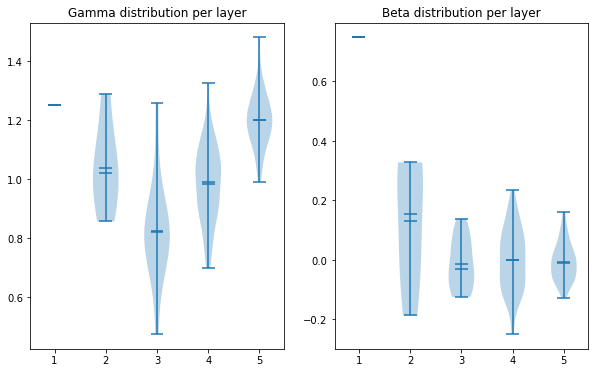

In [98]:
# Plot distribution of batch norm parameters for each layer
bn_params = bn_model.get_bn_params(to_float=True)

num_bn_layers = len(bn_params)

gammas, betas = zip(*bn_params)

layer_nums = list(range(1, num_bn_layers + 1))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

axs[0].violinplot(gammas, layer_nums, showmeans=True, showextrema=True, showmedians=True, bw_method='silverman')
axs[0].set_title('Gamma distribution per layer')

axs[1].violinplot(betas, layer_nums, showmeans=True, showextrema=True, showmedians=True, bw_method='silverman')
axs[1].set_title('Beta distribution per layer')

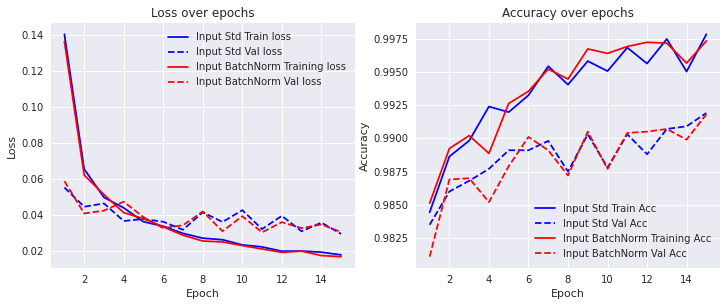

In [99]:
# Compare train/test accuracy and loss for the two cases
# temporarily change the style of the plots to seaborn 
plt.style.use('seaborn')

xs = range(1, len(norm_losses[0]) + 1)
fig, ax = plt.subplots(ncols=2, figsize = (12, 4.5))
ax[0].plot(xs, norm_losses[0], color='blue', label='Input Std Train loss') 
ax[0].plot(xs, norm_losses[1], "--", color='blue', label='Input Std Val loss')
ax[0].plot(xs, bn_losses[0], color='red', label='Input BatchNorm Training loss') 
ax[0].plot(xs, bn_losses[1], "--", color='red', label='Input BatchNorm Val loss')

ax[0].set(title="Loss over epochs", 
        xlabel='Epoch',
        ylabel='Loss') 
ax[0].legend()

ax[1].plot(xs, norm_accs[0], color='blue', label='Input Std Train Acc') 
ax[1].plot(xs, norm_accs[1], "--", color='blue', label='Input Std Val Acc')
ax[1].plot(xs, bn_accs[0], color='red', label='Input BatchNorm Training Acc') 
ax[1].plot(xs, bn_accs[1], "--", color='red', label='Input BatchNorm Val Acc')

ax[1].set(title="Accuracy over epochs", 
        xlabel='Epoch',
        ylabel='Accuracy') 
ax[1].legend()


fig.show()

# change the plot style to default

plt.style.use('default')

The blue/red dotted lines represent the validation accuracy for the standard norm / batch norm models (respectively). Batch normalization for the input layer **did not** improve performance.

## 3.4

In [100]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(N_CLASSES, input_tf="dropout", model_tf="dropout").to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Finished construction model with input_tf: dropout and model_tf: dropout
TF layers:  [Dropout(p=0.2, inplace=False), Identity(), Dropout(p=0.5, inplace=False), Identity(), Dropout(p=0.5, inplace=False), Identity(), Dropout(p=0.5, inplace=False), Identity(), Dropout(p=0.5, inplace=False), Identity()]
LeNet5(
  (feature_extractor): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Identity()
    (2): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (3): Tanh()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Identity()
    (7): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Dropout(p=0.5, inplace=False)
    (11): Identity()
    (12): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (13): Tanh()
    (14): Dropout(p=0.5, inplace=False)
    (15): Identity()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84,

In [101]:
dropout_model, dropout_optimizer, dropout_losses, dropout_accs = training_loop(
    model, criterion, optimizer, train_loader, val_loader, N_EPOCHS, DEVICE)

15:44:55 --- Epoch: 0	Train loss: 0.5845	Valid loss: 0.2084	Train accuracy: 93.54	Valid accuracy: 93.94
15:45:18 --- Epoch: 1	Train loss: 0.3858	Valid loss: 0.1436	Train accuracy: 95.39	Valid accuracy: 95.73
15:45:41 --- Epoch: 2	Train loss: 0.3407	Valid loss: 0.1231	Train accuracy: 96.03	Valid accuracy: 96.36
15:46:04 --- Epoch: 3	Train loss: 0.3165	Valid loss: 0.1094	Train accuracy: 96.57	Valid accuracy: 96.66
15:46:28 --- Epoch: 4	Train loss: 0.2997	Valid loss: 0.1052	Train accuracy: 96.79	Valid accuracy: 96.93
15:46:51 --- Epoch: 5	Train loss: 0.2927	Valid loss: 0.1032	Train accuracy: 96.98	Valid accuracy: 97.09
15:47:14 --- Epoch: 6	Train loss: 0.2844	Valid loss: 0.0911	Train accuracy: 97.13	Valid accuracy: 97.36
15:47:37 --- Epoch: 7	Train loss: 0.2796	Valid loss: 0.0961	Train accuracy: 97.08	Valid accuracy: 97.20
15:48:00 --- Epoch: 8	Train loss: 0.2730	Valid loss: 0.0952	Train accuracy: 97.07	Valid accuracy: 97.28
15:48:24 --- Epoch: 9	Train loss: 0.2748	Valid loss: 0.0872	Trai

In [103]:
norm_accs

([0.9844333529472351,
  0.9886333346366882,
  0.9898166656494141,
  0.9923833608627319,
  0.9919666647911072,
  0.993233323097229,
  0.9954166412353516,
  0.9940333366394043,
  0.9958000183105469,
  0.9950500130653381,
  0.9968166947364807,
  0.9956166744232178,
  0.9974666833877563,
  0.9950166940689087,
  0.9978166818618774],
 [0.9835000038146973,
  0.9860000014305115,
  0.9868000149726868,
  0.9876999855041504,
  0.9890999794006348,
  0.9890999794006348,
  0.989799976348877,
  0.987500011920929,
  0.9902999997138977,
  0.9878000020980835,
  0.9902999997138977,
  0.9887999892234802,
  0.9907000064849854,
  0.9908999800682068,
  0.9919000267982483])

In [104]:
print(f"Input Std accuracy: {norm_accs[1][-1]}")
print(f"Batch norm accuracy: {bn_accs[1][-1]}")
print(f"Dropout accuracy: {dropout_accs[1][-1]}")

Input Std accuracy: 0.9919000267982483
Batch norm accuracy: 0.9918000102043152
Dropout accuracy: 0.9758999943733215


As we can see, using dropout on the input reduced the accuracy of the model, from 0.99 to 0.96, so did not improve overall performance

## 3.5

In [105]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(N_CLASSES, input_tf="bn_dropout", model_tf="bn_dropout").to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Finished construction model with input_tf: bn_dropout and model_tf: bn_dropout
TF layers:  [BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Dropout(p=0.2, inplace=False), BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Dropout(p=0.5, inplace=False), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Dropout(p=0.5, inplace=False), BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Dropout(p=0.5, inplace=False), BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Dropout(p=0.5, inplace=False)]
LeNet5(
  (feature_extractor): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (3): Tanh()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): BatchNorm2d(6, eps=1e-05, momentum=0.1, af

In [106]:
bn_dropout_model, bn_dropout_optimizer, bn_dropout_losses, bn_dropout_accs = training_loop(
    model, criterion, optimizer, train_loader, val_loader, N_EPOCHS, DEVICE)

15:52:18 --- Epoch: 0	Train loss: 0.5705	Valid loss: 0.1325	Train accuracy: 95.81	Valid accuracy: 96.00
15:52:46 --- Epoch: 1	Train loss: 0.3263	Valid loss: 0.0956	Train accuracy: 96.85	Valid accuracy: 96.99
15:53:14 --- Epoch: 2	Train loss: 0.2885	Valid loss: 0.0942	Train accuracy: 96.96	Valid accuracy: 96.99
15:53:42 --- Epoch: 3	Train loss: 0.2698	Valid loss: 0.0816	Train accuracy: 97.33	Valid accuracy: 97.65
15:54:10 --- Epoch: 4	Train loss: 0.2579	Valid loss: 0.0800	Train accuracy: 97.36	Valid accuracy: 97.57
15:54:38 --- Epoch: 5	Train loss: 0.2531	Valid loss: 0.0809	Train accuracy: 97.50	Valid accuracy: 97.63
15:55:06 --- Epoch: 6	Train loss: 0.2438	Valid loss: 0.0737	Train accuracy: 97.70	Valid accuracy: 97.88
15:55:34 --- Epoch: 7	Train loss: 0.2411	Valid loss: 0.0776	Train accuracy: 97.62	Valid accuracy: 97.70
15:56:01 --- Epoch: 8	Train loss: 0.2352	Valid loss: 0.0758	Train accuracy: 97.76	Valid accuracy: 97.79
15:56:29 --- Epoch: 9	Train loss: 0.2358	Valid loss: 0.0707	Trai

In [108]:
print(f"Batch norm accuracy: {bn_accs[1][-1]}")
print(f"Dropout accuracy: {dropout_accs[1][-1]}")
print(f"Batch Norm + Dropout accuracy: {bn_dropout_accs[1][-1]}")

Batch norm accuracy: 0.9918000102043152
Dropout accuracy: 0.9758999943733215
Batch Norm + Dropout accuracy: 0.98089998960495


Using batch normalization and dropout improved the performance slightly over *just* dropout, but both are still worse than simply using batch normalization on the input.

# Problem 4 - *Universal Approximators: Depth Vs. Width*

## 4.1

### Generate our dataset

In [109]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

np.random.seed(42)
num_points = 5000
split_idx = int(num_points * 0.8)

def f(x1, x2):
    a = np.sqrt(np.fabs(x2 + x1 / 2 + 47))
    b = np.sqrt(np.fabs(x1 - (x2 + 47)))
    return -(x2+47) * np.sin(a) - x1 * np.sin(b)

def y(x1, x2):
    return f(x1, x2) + np.random.normal(0, 0.3)

xs = np.array([np.random.uniform(-512, 512, size=2) for _ in range(num_points)])
xs = xs.astype(float)
ys = np.array([y(x[0], x[1]) for x in xs])
ys = np.expand_dims(ys, 1)

# Already randomly generated points so can just split at 80%
train_x, test_x = xs[:split_idx], xs[split_idx:]
train_y, test_y = ys[:split_idx], ys[split_idx:]

class EggholderDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
        
    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

train_ds = EggholderDataset(train_x, train_y)
test_ds = EggholderDataset(test_x, test_y)

len(train_ds), len(test_ds)

(4000, 1000)

### Generate our list of model variations

In [110]:
from itertools import chain, combinations
import pandas as pd

import itertools

num_units = [16, 32, 64, 128, 256, 512]
max_neurons = 512
max_size = 3

def all_permutations(items):
    [p for p in itertools.product(items, repeat=3)]


def create_layer_configs():
    configs = ([p for p in itertools.product(num_units, repeat=1)] + 
              [p for p in itertools.product(num_units, repeat=2)] + 
              [p for p in itertools.product(num_units, repeat=3)])
    # Keep only those with less than 512 neurons
    configs = [config for config in configs if np.sum(config) <= max_neurons]
    # Pad with None up to size 3
    configs = [config + (None,) * (max_size - len(config)) for config in configs]

    return configs


all_configs = create_layer_configs()

df = pd.DataFrame(data=all_configs,
                  columns=["layer_1_sz", "layer_2_sz", "layer_3_sz"])
df["total_units"] = df.sum(axis=1)
df["num_layers"] = max_size - df.isnull().sum(axis=1)
# TODO add total_params, RMSE, and training time

df

,layer_1_sz,layer_2_sz,layer_3_sz,total_units,num_layers
0,16,NaN,NaN,16.0,1
1,32,NaN,NaN,32.0,1
2,64,NaN,NaN,64.0,1
3,128,NaN,NaN,128.0,1
4,256,NaN,NaN,256.0,1
...,...,...,...,...,...
138,256,64.0,128.0,448.0,3
139,256,128.0,16.0,400.0,3
140,256,128.0,32.0,416.0,3
141,256,128.0,64.0,448.0,3


In [111]:
# Let's just take one model config for each number of units

config_df = df.groupby(["total_units", "num_layers"]).first().reset_index()
config_df = config_df.sort_values(["num_layers", "total_units", "layer_1_sz", "layer_2_sz", "layer_3_sz"])
config_df = config_df.reset_index()
config_df

,index,total_units,num_layers,layer_1_sz,layer_2_sz,layer_3_sz
0,0,16.0,1,16,NaN,NaN
1,1,32.0,1,32,NaN,NaN
2,5,64.0,1,64,NaN,NaN
3,13,128.0,1,128,NaN,NaN
4,25,256.0,1,256,NaN,NaN
5,42,512.0,1,512,NaN,NaN
6,2,32.0,2,16,16.0,NaN
7,3,48.0,2,16,32.0,NaN
8,6,64.0,2,32,32.0,NaN
9,8,80.0,2,16,64.0,NaN


In [112]:
# Manually removed some unnecessary model configs due to time
# We have a max of 10 configs per num_layers
config_df = pd.read_csv("configs.csv")
config_df

,total_units,num_layers,layer_1_sz,layer_2_sz,layer_3_sz
0,16,1,16,NaN,NaN
1,16,1,16,NaN,NaN
2,32,1,32,NaN,NaN
3,64,1,64,NaN,NaN
4,128,1,128,NaN,NaN
5,256,1,256,NaN,NaN
6,512,1,512,NaN,NaN
7,32,2,16,16.0,NaN
8,32,2,16,16.0,NaN
9,64,2,32,32.0,NaN


I ran the following cell as a python script from a batch job running on green

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import pandas as pd
from tqdm import tqdm
from torch.optim import SGD, Adam
tqdm.pandas()
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--num_layers", type=int)
    
    args = parser.parse_args()
    return args

np.random.seed(42)
num_points = 100000

EPOCHS = 2000
BATCH_SIZE = 1000

split_idx = int(num_points * 0.8)

def f(x1, x2):
    a = np.sqrt(np.fabs(x2 + x1 / 2 + 47))
    b = np.sqrt(np.fabs(x1 - (x2 + 47)))
    return -(x2+47) * np.sin(a) - x1 * np.sin(b)

def y(x1, x2):
    return f(x1, x2) + np.random.normal(0, 0.3)

xs = np.array([np.random.uniform(-512, 512, size=2) for _ in range(num_points)])
xs = xs.astype(float)
ys = np.array([y(x[0], x[1]) for x in xs])
ys = np.expand_dims(ys, 1)
# ys = [x[0] + x[1] for x in xs]

# Already randomly generated points so can just split at 80%
train_x, test_x = xs[:split_idx], xs[split_idx:]
train_y, test_y = ys[:split_idx], ys[split_idx:]

class EggholderDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
        
    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

from torch.nn.modules.batchnorm import BatchNorm1d
from torch import nn
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
tqdm.pandas()
import time
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NN1Layer(nn.Module):
    def __init__(self, layer_1_sz):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, layer_1_sz),
            nn.ReLU(),
            nn.BatchNorm1d(layer_1_sz),
            nn.Linear(layer_1_sz, 1)
        )

    def forward(self, x):
        return self.model(x)
    
class NN2Layer(nn.Module):
    def __init__(self, layer_1_sz, layer_2_sz):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, layer_1_sz),
            nn.ReLU(),
            nn.BatchNorm1d(layer_1_sz),
            nn.Linear(layer_1_sz, layer_2_sz),
            nn.ReLU(),
            nn.BatchNorm1d(layer_2_sz),
            nn.Linear(layer_2_sz, 1)
        )

    def forward(self, x):
        return self.model(x)
    
class NN3Layer(nn.Module):
    def __init__(self, layer_1_sz, layer_2_sz, layer_3_sz):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, layer_1_sz),
            nn.ReLU(),
            nn.BatchNorm1d(layer_1_sz),
            nn.Linear(layer_1_sz, layer_2_sz),
            nn.ReLU(),
            nn.BatchNorm1d(layer_2_sz),
            nn.Linear(layer_2_sz, layer_2_sz),
            nn.ReLU(),
            nn.BatchNorm1d(layer_2_sz),
            nn.Linear(layer_2_sz, 1)
        )

    def forward(self, x):
        return self.model(x)

def train_model(row):    
    n_layers = row["num_layers"]
    if n_layers == 1:
        model = NN1Layer(int(row["layer_1_sz"]))
    elif n_layers == 2:
        model = NN2Layer(int(row["layer_1_sz"]), int(row["layer_2_sz"]))
    elif n_layers == 3:
        model = NN3Layer(int(row["layer_1_sz"]), int(row["layer_2_sz"]), int(row["layer_3_sz"]))
        
    model = model.to(device)

    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    criterion = nn.MSELoss()
    optm = SGD(model.parameters(), lr = 1e-4, momentum=0.9, nesterov=True)


#     pbar = tqdm(range(EPOCHS))
    pbar = range(EPOCHS)
    ds_len = len(train_ds)
    print(f"Beginning training on row: {row}")
    start_time = time.time()
    # start training
    for epoch in pbar:
        running_mse = 0
        for step, (x_train, y_train) in enumerate(train_dataloader):
            x_train = x_train.float()
            y_train = y_train.float()

            x_train = x_train.to(device)
            y_train = y_train.to(device)

            prediction = model(x_train)   # input x and predict based on x

            running_mse += ((prediction - y_train)**2).sum().data

            loss = criterion(prediction, y_train)     # must be (1. nn output, 2. target)

            optm.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optm.step()        # apply gradients

        train_mse = round(torch.sqrt(running_mse / ds_len).item(), 2)
    
    end_time = time.time()
    total_time = round(end_time - start_time, 2)  
    
    # Run the model on the test set after finishing training
    running_mse = 0
    ds_len = len(test_ds)
    model.eval()
    for step, (x_test, y_test) in enumerate(test_dataloader):
        x_test = x_test.float()
        y_test = y_test.float()

        x_test = x_test.to(device)
        y_test = y_test.to(device)

        prediction = model(x_test)   # input x and predict based on x

        running_mse += ((prediction - y_test)**2).sum().data

    test_mse = round(torch.sqrt(running_mse / ds_len).item(), 2)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return train_mse, test_mse, total_time, total_params

train_ds = EggholderDataset(train_x, train_y)
test_ds = EggholderDataset(test_x, test_y)

print(len(train_ds), len(test_ds))

config_df = pd.read_csv("configs.csv")

args = parse_args()

config_df = config_df[config_df["num_layers"] == args.num_layers]

config_df["results"] = config_df.progress_apply(train_model, axis=1)
print(config_df)

config_df.to_csv(f"results_{args.num_layers}_{time.time()}.csv", index=False)


Read the results in

In [215]:
import re


# Now we can read in the results
# Parse the results csv into a usable dataframe
results = pd.read_csv("results.csv")
results[["train_mse", "test_mse", "runtime", "num_params"]] = results["results"].str.split(",", expand=True)
# Strip off the brackets, automatically saved by pandas
results["train_mse"] = results["train_mse"].apply(lambda x: x[1:])
results["num_params"] = results["num_params"].apply(lambda x: x[:-1])

for col in ["train_mse", "test_mse", "runtime", "num_params"]:
    results[col] = pd.to_numeric(results[col])

results = results.drop("results", axis=1)
# results = pd.to_numeric(results)
results

,total_units,num_layers,layer_1_sz,layer_2_sz,layer_3_sz,train_mse,test_mse,runtime,num_params
0,16,1,16,NaN,NaN,293.11,292.21,1284.61,97
1,32,1,32,NaN,NaN,293.41,291.48,1302.15,193
2,64,1,64,NaN,NaN,293.09,292.36,1297.85,385
3,128,1,128,NaN,NaN,292.09,291.19,1286.71,769
4,256,1,256,NaN,NaN,291.80,291.30,1279.28,1537
5,512,1,512,NaN,NaN,291.51,292.39,1274.31,3073
6,32,2,16,16.0,NaN,175.85,162.20,1338.37,401
7,64,2,32,32.0,NaN,169.38,163.24,1323.89,1313
8,80,2,16,64.0,NaN,166.98,165.70,1336.18,1361
9,128,2,64,64.0,NaN,155.12,136.12,1344.23,4673


In [228]:
# Plot RMSE against total hidden units
def get_values(x, y):
    custom_df = results.sort_values(x)
    layer1 = custom_df.loc[results["num_layers"] == 1]
    layer2 = custom_df.loc[results["num_layers"] == 2]
    layer3 = custom_df.loc[results["num_layers"] == 3]
    
    # Return tuples of x, y for layers 1, 2, 3
    return (layer1[x], layer1[y]), (layer2[x], layer2[y]), (layer3[x], layer3[y])

def plot_results(x, y):
    layer1, layer2, layer3 = get_values(x, y)
    
    plt.plot(layer1[0], layer1[1], label="Layer 1")
    plt.plot(layer2[0], layer2[1], label="Layer 2")
    plt.plot(layer3[0], layer3[1], label="Layer 3")
    ax = plt.gca()
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    # ax.invert_yaxis()
    # ax.xaxis.set_major_locator(plt.MaxNLocator(7))
    # ax.yaxis.set_major_locator(plt.MaxNLocator(10))
    plt.legend()
    plt.show()

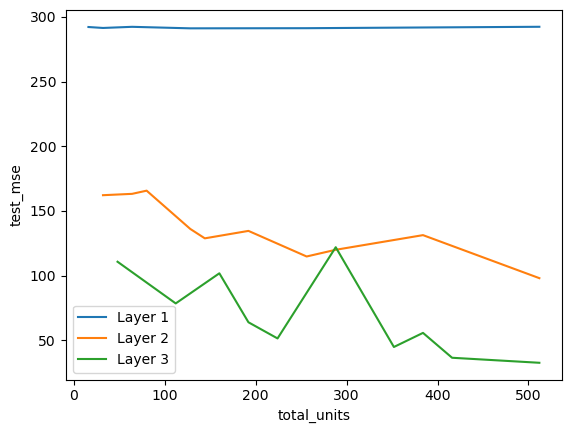

In [231]:
plot_results("total_units", "test_mse")

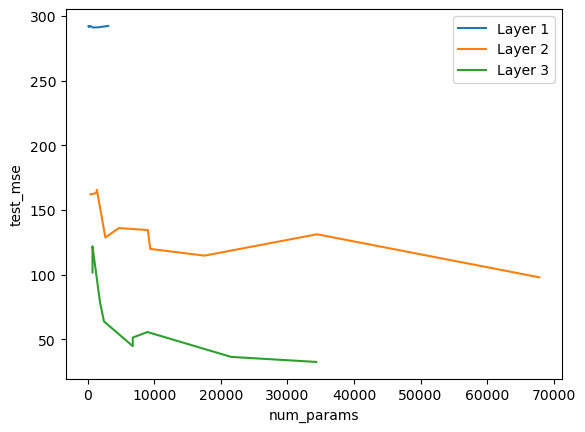

In [230]:
plot_results("num_params", "test_mse")

## 4.2

As expected, the general trend is for all models' RMSE to increase (i.e., performance degrades) as we go from deeper to shallower networks. The **three layer** network outperforms all other networks at almost all configurations, indicating that for this dataset, it is more effective to scale **deeper** rather than **wider**. 

For the **two** and **three** layer models, we see a pretty significant improvement in performance initially as we scale up, however, this trend plateaus after ~20k parameters.

Although minor, the **single layer** model's error also decreases as we add more units, however, to a lesser degree than the **two** and **three layer** models.

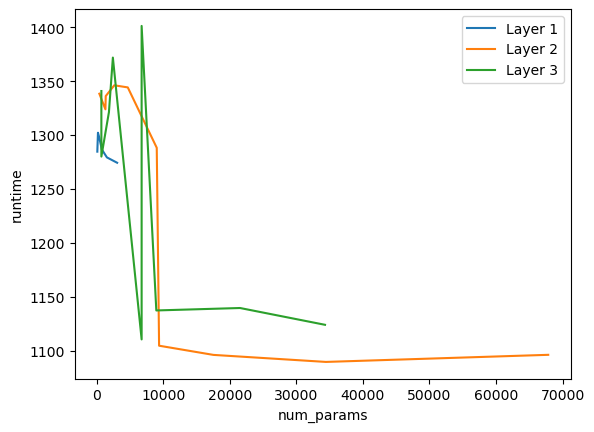

In [232]:
plot_results("num_params", "runtime")

While training the models on Greene, I had to run multiple training jobs on the same machine to avoid my job being killed due to "low GPU utilisation" - this is because of the small networks, simple dataset, and fixed batch size. The noise created by these multiple models being run on the same GPU has caused the recorded model training time to fluctuate significantly for each model.

Despite these difficulties, it is still possible to draw conclusions from the data; mainly, that the runtime wasn't **significantly** affected by the number of parameters. One may expect to see a linear increase in training time as we increase # of parameters, but the training time increases only slightly.

This indicates that the runtime/performance tradeoff is in favor of performance - it is generally advisable to increase parameterisation, for the training time will only increase by a fraction of the amount.

# Problem 5 - *Learning Rate, Batch Size, FashionMNIST*

## 5.1

In [11]:
%cd "/content/drive/MyDrive/NYU/DL Systems/004-HW2/cyclical_finder"
!ls -l

/content/drive/MyDrive/NYU/DL Systems/004-HW2/cyclical_finder
total 19
-rw------- 1 root root 5797 Oct 12  2020 cyclical-learning.ipynb
drwx------ 2 root root 4096 Oct 12  2020 output
drwx------ 2 root root 4096 Oct 12  2020 pyimagesearch
-rw------- 1 root root 4937 Oct 12  2020 train-fashionmnist.py


In [233]:
BATCH_SIZE = 64
LRs = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
NUM_EPOCH = 5

LRs

[1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [235]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib

matplotlib.use("Agg")

# import the necessary packages
from pyimagesearch.minigooglenet import MiniGoogLeNet
from pyimagesearch.clr_callback import CyclicLR
from pyimagesearch import config
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
# from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys



ModuleNotFoundError: No module named 'tensorflow'

In [13]:
img_witdth, img_height = 32, 32


# load the training and testing data, converting the images from
# integers to floats
print("[INFO] loading Fashion MNIST data...")

((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# ((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

[INFO] loading Fashion MNIST data...
4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (img_witdth, img_height)) for x in trainX])
testX = np.array([cv2.resize(x, (img_witdth, img_height)) for x in testX])

# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0


# reshape the data matrices to include a channel dimension (required
# for training)

trainX = trainX.reshape((trainX.shape[0], img_witdth, img_height, 1))
testX = testX.reshape((testX.shape[0], img_witdth, img_height, 1))


# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

